# Mining Positive and Negative Examples for Training

In the previous notebook (`03_query_gen_solution.ipynb`), we focused on generating a diverse and high-quality set of synthetic queries related to the EU AI Act. We used techniques like grounding, personas, few-shot examples, and quality filtering to create realistic questions paired with the specific passage they were generated from.

However, simply having a query and its source passage isn't enough to effectively fine-tune a powerful embedding model. We need a structured dataset that clearly tells the model:
1.  Which passages are highly relevant (positive examples) for a given query.
2.  Which passages are irrelevant or only semantically related (negative examples) to the query.

This notebook bridges the gap between generating synthetic data and preparing it for fine-tuning. We'll dive into the **positive and negative documents mining**. Our goal is to transform the query-passage pairs generated previously into a robust training dataset containing `(query, positive_passage, negative_passages)` triplets.

\

### Why Mine Positives and Negatives?

Embedding models learn to map text to dense vector spaces where semantic similarity corresponds to proximity. To train them effectively, especially for information retrieval tasks, we need to explicitly teach them:
* Pull the vector representation of a query *closer* to the vector of its relevant passage(s).
* Push the vector representation of a query *away* from the vectors of irrelevant passages.

A key challenge is that the original passage used to generate a query isn't always the *single best* answer within the entire corpus. Furthermore, simply using random irrelevant passages as negatives isn't optimal. The model learns more effectively when challenged with hard negatives: passages that are semantically similar to the query (e.g., using similar keywords) but don't actually answer it.

\


## Setup

> ***Important:*** *If you want to evaluate or train the models in this notebook, make sure to have a GPU runtime enabled. Click on `Runtime` > `Change runtime type` > Select `T4 GPU` and Save.*

> *Also, to make sure there are no older sessions running, click on `Runtime` > `Manage sessions` > `Terminate other sessions`*

In [ ]:
import os
import time
from typing import Dict, Any, Optional, List
from google import genai
from google.colab import userdata
from google.genai import types

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")  # alternatively paste your key here
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

In [ ]:
def generate_text(
    prompt: str,
    model: str = "gemini-2.0-flash",
    temperature: Optional[float] = None,
    max_tokens: Optional[int] = None,
    system_instructions: Optional[str] = None
) -> str:
    """
    Generate text using Google's Gemini model with configurable parameters.

    Args:
        prompt: The user prompt to send to the model
        model: Model name to use (default: gemini-2.0-flash)
        temperature: Controls temperature (0.0-2.0, lower is more deterministic)
        max_tokens: Maximum number of tokens to generate
        system_instructions: Optional system instruction to guide the model

    Returns:
        Generated text response as string
    """
    try:
        # Create config with only non-None parameters
        config_params = {}
        if temperature:
            config_params["temperature"] = temperature
        if max_tokens is not None:
            config_params["max_output_tokens"] = max_tokens
        if system_instructions:
            config_params["system_instruction"] = system_instructions

        # Create the config object
        config = types.GenerateContentConfig(**config_params)

        # Generate content
        response = client.models.generate_content(
            model=model,
            contents=[prompt],
            config=config
        )

        return response.text
    except Exception as e:
        return f"Error generating text: {str(e)}"

In [ ]:
%%capture
# Install dependencies, download synthetic dataset and embedding models (will take ~2 minutes)
!wget "https://drive.google.com/uc?export=download&id=1KE2cvFbV8B_HI7uFBqoEJ_2Ao82a80xX" -O ./training_queries.csv
# load the corpus with already pre-computed embeddings
!wget "https://drive.google.com/uc?export=download&id=1NO42oUkoq5fcyXFo70qN1sJMqntC5fN7" -O ./aiact_corpus.csv

!pip install FlagEmbedding

import numpy as np
from FlagEmbedding import BGEM3FlagModel, FlagReranker

bge_model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

---
## Defining Training Examples: Positives, Negatives, and Hard Negatives
For training embedding models, we utilize:
* positive pairs: `query` + `relevant document`
* negative pairs: `query` + `negative document`
   - negative document = document not related to the query
   - hard negative document = semantically similar document to the query but does not answer it

#### Example:
Query: <i>"What are the health benefits of drinking water?"</i>

| Type | Document | Explanation |
|------|----------|-------------|
| **Positive document** | "Drinking adequate water improves cognitive performance and energy levels throughout the day." | Directly answers the question about health benefits of drinking water |
| **Negative document** | "Germany is a country in Central Europe. It lies between the Baltic and North Seas to the north and the Alps to the south." | Is about a completely different topic with no relation to water or health |
| **Hard Negative** | "The average adult human body is composed of approximately 60% water." | Talks about "water" and "human body" but does not answer the question about health benefits |

This `(query, positive, negative)` structure forms the basis of contrastive learning, a common technique for training embedding models. The model learns by maximizing the similarity between the query and its positive passage while minimizing the similarity between the query and its negative passages.

\

#### Why do we want hard negatives?
The training signal (loss) is stronger from hard negative documents than from standard negative documents, as untrained models struggle more to distinguish them from positives. Therefore, incorporating hard negatives into training significantly improves model performance.

A critical consideration is how to obtain quality negatives. The primary challenge for any method is avoiding false positives—documents incorrectly identified as hard negatives when they actually contain relevant information.  Mislabelled negatives can confuse the model during training, teaching it to push away relevant information. Therefore, careful selection is essential.


---


### Our Approach: Inspired by Google's Gecko

We will follow a methodology inspired by Google's [Gecko: Versatile Text Embeddings Distilled from Large Language Models](https://arxiv.org/abs/2403.20327) paper. This involves:

0. **Query Generation:** Generate synthetic queries from passages. The authors of the Gecko paper used a method based on [Promptagator](https://arxiv.org/abs/2209.11755). We will use the queries generated in the previous notebook.
1.  **Initial Retrieval:** Using an existing embedding model (a bi-encoder) to quickly find a broad set of candidate passages for each query.
2.  **Reranking for Quality:** Employing more powerful (but slower) models like Large Language Models (LLMs) or cross-encoders to re-evaluate and re-order the candidate passages based on relevance.
3.  **Positive Passage Refinement:** The source document for the query is not necessarily always the most relevant document. The goal of this step is to identify the best positive passage from the reranked list, which might differ from the original source passage.
4.  **Hard Negative Mining:** Selecting challenging negative examples from the reranked list – specifically, passages ranked relatively high (indicating similarity) but not high enough to be considered positive.

By the end of this notebook, you'll understand how to curate high-quality positive and negative examples, resulting in a dataset ready for fine-tuning an embedding model in the next notebook (`05_finetuning.ipynb`).

<details>
<summary><b>Click to view:</b> more details about the Gecko paper</summary>

### Google's approach
In this paper from Google: [Gecko: Versatile Text Embeddings Distilled from Large Language Models](https://arxiv.org/abs/2403.20327), they followed this methodology for creating the training dataset:

#### 1. Synthetic query generation
 - using [Promptagator](https://arxiv.org/abs/2209.11755) approach

#### 2. Positive documents mining
 - The authors discovered that the document $p$ from which the synthetic query $q$ was generated: $LLM(p) \rightarrow q$, **does not always need to be the most relevant document to that query**
 - Therefore they first utilize an existing embedding model to retrieve top-100 passages
 - Subsequently, they use two LLMs as rerankers. And keep the source document as the positive document only if it is still the top document after the reranking.
 - The authors found out that for their dataset, the source document was replaced in about 15 % of the cases

#### 3. Hard negative mining
 - Using an existing embedding model to retrieve top-$k$ documents and then rerank them using the same LLMs
 - After the reranking, they use the 20th document as a hard negative

For the LLM ranking, they implemented two methods:
1. Query Likelihood: measure the log-likelihood of a generated query $q$, given a passage $p$ and rerank the docs based on the probability.
  * more in [(Sachan et al., 2022)](https://aclanthology.org/2022.emnlp-main.249.pdf)
2. Rlevance Classification: log-likelihood of a relevance label given the query and a passage.
  * provide the LLM with fine-grained relevance labels, such as “Highly Relevant”, “Somewhat Relevant” and “Not Relevant” and collect their token likelihood score
  * more in [(Zhuang et al., 2023)](https://arxiv.org/pdf/2310.14122)


They use these two different approaches and then combine the results using Reciprocal Rank Fusion (RRF).
* <i>They find that the relabeling of the positive passage (i.e., $p^+ \neq p_{seed}$) happens for about 15% in the dataset </i>.

</details>

\

## Our Mining Strategy: Retrieval + Reranking

As outlined in the introduction, we'll adopt a multi-stage approach inspired by the Gecko paper to find the best positive and informative hard negatives.

**Step 1: Initial Retrieval (Bi-Encoder)**
We start by using a bi-encoder embedding model (like BGE-M3 in this case). Bi-encoders create embeddings for the query and passages independently. This allows for very efficient searching over large corpora to find an initial set of candidate passages (e.g., the top 100 most similar). While fast, bi-encoders might not always capture the nuances of relevance perfectly.

**Step 2: Reranking (LLM / Cross-Encoder)**
Next, we take the top candidates from the bi-encoder and re-evaluate them using more powerful but computationally intensive rerankers. Unlike bi-encoders, rerankers (like LLMs configured for ranking or specialized cross-encoders) process the query and each candidate passage together. This allows for a deeper understanding of their relationship and produces a more accurate relevance score.

**Step 3: Positive and Negative Selection**
Finally, we use the refined order from the reranker(s) to:
* Select the top-ranked passage as our positive example.
* Select passages from further down the ranked list (e.g., ranks 10-20) as our hard negative examples.

<img src="https://drive.google.com/uc?export=view&id=1FeiCAUtX8N5LQkwXsVIckeNTSVmJkvbC" alt="Evaluation metrics" width="700">

Let's start with the initial retrieval.


# Step 1: Retrieve top-k documents for each synthetic query

After generating synthetic queries in the previous notebooks, we need to search the top-k documents for each query using an existing embedding model. In this notebook we will utilize BGE-M3 embedding model.



In [ ]:
# Let's start by loading the synthetic queries

import pandas as pd
df = pd.read_csv("training_queries.csv").iloc[:10]  # we will only work with a sample of 10 queries here
print(len(df))
df.head(3)

10


,psg_id,passage,persona,query_style,query,method,critique,score
0,0,Preamble\n\n(1)The purpose of this Regulation ...,A healthcare professional working with diagnos...,Simple direct question with basic vocabulary,How does the EU's AI Act ensure patient safety...,few-shot,The query is relevant as it pertains to the re...,4
1,0,Preamble\n\n(1)The purpose of this Regulation ...,A privacy advocate with a background in civil ...,Hypothetical scenario-based question,In a scenario where a new AI system is develop...,zero-shot,The query is relevant as it addresses the regu...,5
2,1,Preamble\n\n(2)This Regulation should be appli...,A journalist who covers technology trends for ...,Informal conversational question,How does the EU's AI Act balance promoting inn...,zero-shot,"The query is relevant and specific, focusing o...",5


In [ ]:
# We no longer need the query details, we will keep just
# - `query`
# - `psg_id` - id of the source document
# - `query_embed` - vector embeddings

questions = df["query"].tolist()
source_documents_ids = df["psg_id"].tolist()

# Calculate embeddings for each query
question_embeddings = bge_model.encode(questions)['dense_vecs']

query_df = pd.DataFrame({
    'query': questions,
    'psg_id': source_documents_ids,
    'query_embed': [q_embed for q_embed in question_embeddings],
})
query_df.head(3)

,query,psg_id,query_embed
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685..."
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00..."
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321..."


In [ ]:
# Load document corpus and computed embeddings
corpus = pd.read_csv('aiact_corpus.csv')

docs = corpus["passage"].tolist()
doc_embeddings = bge_model.encode(docs)['dense_vecs']
corpus["doc_embed"] = [d_embed for d_embed in doc_embeddings]
corpus.head(3)

Inference Embeddings: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


,psg_id,passage,source,doc_embed
0,0,Preamble\n\n(1)The purpose of this Regulation ...,preamble,"[-0.02101, -0.001238, -0.0364, 0.01228, -0.013..."
1,1,Preamble\n\n(2)This Regulation should be appli...,preamble,"[0.008675, 0.01949, -0.0412, 0.01488, -0.06256..."
2,2,Preamble\n\n(3)AI systems can be easily deploy...,preamble,"[-0.0001527, 0.01724, -0.05405, 0.006863, 0.00..."


In [ ]:
# Now retrieve top-100 documents for each query based on cos similarity between query and docs
import torch
import torch.nn.functional as F

def top_k_documents(query_embeddings, document_embeddings, k=10):
    """
    Finds the top-k most similar documents for each query.

    Args:
        query_embeddings
        document_embeddings
        k: The number of top documents to retrieve for each query.

    Returns:
        A tuple: (top_k_scores, top_k_indices).
            top_k_scores: A tensor of shape (num_queries, k) containing the
                          cosine similarity scores of the top-k documents.
            top_k_indices: A tensor of shape (num_queries, k) containing the
                           indices of the top-k documents in the
                           document_embeddings tensor.
    """
    # 0. Convert to pytorch
    if hasattr(document_embeddings, 'values'):
        document_embeddings = np.stack(document_embeddings.values)
    if hasattr(query_embeddings, 'values'):
        query_embeddings = np.stack(query_embeddings.values)

    query_embeddings = torch.from_numpy(query_embeddings)
    document_embeddings = torch.from_numpy(document_embeddings)
    print(f"Number of documents x embedding dim: {document_embeddings.shape}")

    # check if query and documents are the same datatype
    if query_embeddings.dtype != document_embeddings.dtype:
        query_embeddings = query_embeddings.to(document_embeddings.dtype)

    # 1. Move tensors to the GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    query_embeddings = query_embeddings.to(device)
    document_embeddings = document_embeddings.to(device)

    # 2. Normalize the embeddings (L2 normalization)
    query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
    document_embeddings = F.normalize(document_embeddings, p=2, dim=1)

    # 3. Compute the cosine similarity matrix
    similarity_matrix = torch.matmul(query_embeddings, document_embeddings.T)

    # 4. Get the top-k scores and indices
    top_k_scores, top_k_indices = torch.topk(similarity_matrix, k=k, dim=1)

    return top_k_scores, top_k_indices

def find_position(df, idx_row='top_indices'):
  positions = []
  for idx, row in df.iterrows():
    try:
        position = np.where(row['psg_id'] == np.array(row[idx_row]))[0][0]
    except IndexError:
        position = 100
    positions.append(position)
  return positions

k = 100
top_scores, top_indices = top_k_documents(query_df['query_embed'], corpus['doc_embed'], k)
query_df['top_indices'] = top_indices.tolist()
query_df['top_scores'] = top_scores.tolist()
query_df['source_doc_rank'] = find_position(query_df)
query_df.head()

Number of documents x embedding dim: torch.Size([787, 1024])


,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685...","[2, 74, 145, 52, 0, 7, 192, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00...","[0, 2, 23, 7, 506, 22, 175, 52, 81, 74, 591, 1...","[0.72998046875, 0.7177734375, 0.7080078125, 0....",0
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321...","[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 74, 9, ...","[0.69287109375, 0.658203125, 0.65478515625, 0....",3
3,In a scenario where a tech company is developi...,1,"[-0.0454, 0.01436, -0.04047, 0.0175, -0.01345,...","[10, 2, 7, 5, 81, 506, 504, 0, 503, 156, 82, 1...","[0.71240234375, 0.70703125, 0.70166015625, 0.6...",11
4,EU AI Act impact on legal certainty for AI dev...,2,"[-0.010765, 0.007534, -0.02034, 0.002092, -0.0...","[2, 5, 156, 7, 151, 0, 67, 8, 134, 500, 189, 6...","[0.65966796875, 0.646484375, 0.6435546875, 0.6...",0


Examining the `source_doc_rank` column (denoting the position of the source document in the top-100 retrieved, most similar documents, according to the bi-encoder), we see the position of the original passage used to generate the query within those top 100 retrieved documents. Notice that the rank isn't always 0; sometimes it's lower, and occasionally it's 100, meaning the source document wasn't found in the top 100 at all. This confirms the finding from the Gecko paper that the source passage isn't always the most relevant.

Our next step is to apply reranking to improve the relevance ordering of these retrieved documents and examine this further.

# Step 2: Reranking (LLM / Cross-Encoder)
We take the top candidates from the bi-encoder and re-evaluate them using more powerful but computationally intensive rerankers. Unlike bi-encoders, rerankers (like LLMs configured for ranking or specialized cross-encoders) process the query and *each* candidate passage *together*. This allows for a deeper understanding of their relationship and produces a more accurate relevance score.

- In the Gecko paper, they used two LLMs for the reranking phase
- Here we will utilize one LLM following the RankGPT paper: [Is ChatGPT Good at Search? Investigating Large Language Models as Re-Ranking Agents](https://arxiv.org/pdf/2304.09542) and instead of the second LLM, we will use a cross-encoder.


## 2.1 LLM as a Reranker
We will start by designing a prompt for the LLM that will act as a reranker. We will follow the RankGPT approach, where the authors explore utilizing LLMs for listwise reranking. A follow-up paper is [RankZephyr](https://arxiv.org/pdf/2312.02724), which builds upon RankGPT by fine-tuning 7B LLM to perform the reranking task.

Here we will utilize a slightly enhanced version of the prompt from RankZephyr.

In [ ]:
# Define a short system prompt
system_prompt = "You are RankLLM, an intelligent assistant that can rank passages based ontheir relevancy to the query."

# Improved ranking prompt from RankZephyr
rank_prompt = """I will provide you with {num} passages, each indicated by a numerical identifier [].

Rank the passages based on their relevance to this search query: '{query}'

## Passages start

{passages}

## Passages end

As a reminder, once more the search query: '{query}'

Rank the {num} passages above based on their relevance to the search query. All the passages should be included and listed using identifiers, in descending order of relevance.

The output format should be a python list of comma separated numerical identifiers, sorted from most to least relevant.

Always make sure to return all {num} passages in your ranking. Never leave out any passage, otherwise you fail the task.

Only respond with the ranking results, do not say any word or explain."""

In [ ]:
import ast
import time
from tqdm import tqdm

def llm_reranker(df, corpus, k=20):
    reranked_docs = []
    print(len(df))
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # Format prompt to include documents
        formatted_docs = "\n\n\n".join(
            [f"[{i+1}]\n\n{corpus.loc[psg_id, 'passage']}" for i, psg_id in enumerate(row["top_indices"][:k])]
        )
        prompt = rank_prompt.format(query=row["query"], passages=formatted_docs, num=k)
        try:
            response = generate_text(prompt, system_instructions=system_prompt)
            print('response: \n', response)
            ranking = list(ast.literal_eval(response.replace("[","").replace("]","").strip("```").replace("python","").strip()))
            reranked_docs.append([row['top_indices'][idx-1] for idx in ranking])
        except Exception as e:
            print(f"\nError processing row {idx}: {e}")
            reranked_docs.append(None)
        time.sleep(1)

    return reranked_docs

# Initialize reranking
reranked_docs = llm_reranker(query_df, corpus)
query_df['reranked_docs_llm'] = reranked_docs
query_df.head(5)

10


  0%|          | 0/10 [00:00<?, ?it/s]

response: 
 ```python
[4, 64, 10, 9, 5, 2, 46, 1, 7, 20, 15, 8, 12, 18, 13, 11, 3, 16, 17, 19, 14]
```


 10%|█         | 1/10 [00:03<00:27,  3.09s/it]

response: 
 ```python
[1, 2, 4, 8, 13, 10, 20, 3, 6, 14, 9, 5, 12, 18, 7, 11, 19, 17, 16, 15]
```


 20%|██        | 2/10 [00:05<00:19,  2.46s/it]

response: 
 ```python
[1, 3, 17, 4, 2, 16, 5, 8, 11, 7, 10, 6, 9, 19, 12, 13, 20, 15, 14, 18]
```


 30%|███       | 3/10 [00:07<00:15,  2.26s/it]

response: 
 ```python
[9, 1, 5, 10, 3, 8, 12, 2, 6, 7, 16, 11, 20, 19, 4, 18, 17, 14, 15, 13]
```


 40%|████      | 4/10 [00:09<00:12,  2.14s/it]

response: 
 ```python
[1, 6, 4, 8, 10, 17, 20, 2, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19]
```


 50%|█████     | 5/10 [00:11<00:10,  2.08s/it]

response: 
 ```python
[1, 3, 7, 6, 20, 5, 14, 2, 9, 12, 10, 11, 16, 4, 13, 8, 15, 17, 18, 19]
```


 60%|██████    | 6/10 [00:13<00:08,  2.06s/it]

response: 
 ```python
[1, 3, 2, 4, 9, 16, 5, 7, 6, 8, 12, 10, 13, 15, 17, 19, 11, 14, 20, 18]
```


 70%|███████   | 7/10 [00:15<00:06,  2.05s/it]

response: 
 ```python
[2, 6, 8, 11, 3, 14, 1, 15, 4, 9, 16, 12, 7, 18, 17, 20, 10, 5, 19, 13]
```


 80%|████████  | 8/10 [00:17<00:04,  2.05s/it]

response: 
 ```python
[2, 1, 5, 9, 11, 7, 8, 13, 15, 16, 3, 4, 19, 14, 10, 6, 20, 18, 17, 12]
```


 90%|█████████ | 9/10 [00:19<00:02,  2.07s/it]

response: 
 ```python
[4, 2, 1, 7, 15, 8, 3, 5, 14, 11, 19, 6, 18, 9, 10, 13, 16, 17, 12, 20]
```


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank,reranked_docs_llm
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685...","[2, 74, 145, 52, 0, 7, 192, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4,"[52, 26, 86, 6, 0, 74, 10, 2, 192, 5, 8, 425, ..."
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00...","[0, 2, 23, 7, 506, 22, 175, 52, 81, 74, 591, 1...","[0.72998046875, 0.7177734375, 0.7080078125, 0....",0,"[0, 2, 7, 52, 9, 74, 229, 23, 22, 10, 81, 506,..."
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321...","[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 74, 9, ...","[0.69287109375, 0.658203125, 0.65478515625, 0....",3,"[7, 0, 200, 1, 2, 195, 5, 52, 6, 8, 54, 10, 50..."
3,In a scenario where a tech company is developi...,1,"[-0.0454, 0.01436, -0.04047, 0.0175, -0.01345,...","[10, 2, 7, 5, 81, 506, 504, 0, 503, 156, 82, 1...","[0.71240234375, 0.70703125, 0.70166015625, 0.6...",11,"[503, 10, 81, 156, 7, 0, 1, 2, 506, 504, 153, ..."
4,EU AI Act impact on legal certainty for AI dev...,2,"[-0.010765, 0.007534, -0.02034, 0.002092, -0.0...","[2, 5, 156, 7, 151, 0, 67, 8, 134, 500, 189, 6...","[0.65966796875, 0.646484375, 0.6435546875, 0.6...",0,"[2, 0, 7, 8, 500, 595, 591, 5, 156, 151, 67, 1..."


---
## 2.2 Reranking using cross-encoder

Next we will rerank the retrieved documents from step 1 using cross-encoder

<details>
<summary><b>Reminder</b>: bi-encoder vs cross-encoder</summary>

<img src="https://drive.google.com/uc?export=view&id=11W3I94b51ausO_cJ8eCGNs3wAsxlRmUd" alt="Evaluation metrics" width="900">


</details>


In [ ]:
def cross_enc_reranker(df, k=20, n=0):
  """
  Args:
  k: how many docs to rerank
  n: threshold for re-sampling
  """
  reranked_docs = []  # Store lists of reranked indices
  print(f"Reranking top {k} documents for {len(df[df['source_doc_rank']>= n])} queries")
  for idx, row in tqdm(df.iterrows(), total=len(df)):  # Iterate through ALL rows
    if row['source_doc_rank'] >= n:
      # Rerank top-k documents
      doc_rating_pairs = []
      for doc_id in row['top_indices'][:k]:
        query = row['query']
        try:
          document = corpus.loc[doc_id, 'passage']
        except IndexError as e:
          print(doc_id, idx,)
          raise e
        score = reranker.compute_score([query, document], normalize=True)[0]
        doc_rating_pairs.append((doc_id, score))

      sorted_pairs = sorted(doc_rating_pairs, key=lambda x: x[1], reverse=True)
      reranked_ids = [pair[0] for pair in sorted_pairs]  # Extract just the IDs
      reranked_docs.append(reranked_ids)
    else:
      # Keep original top_indices if source_position < n
      reranked_docs.append(row['top_indices'][:k])

  return reranked_docs

reranked_docs = cross_enc_reranker(query_df, k=20, n=0)
query_df['reranked_docs_ce'] = reranked_docs
query_df.head()

Reranking top 20 documents for 10 queries


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank,reranked_docs_llm,reranked_docs_ce
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685...","[2, 74, 145, 52, 0, 7, 192, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4,"[52, 26, 86, 6, 0, 74, 10, 2, 192, 5, 8, 425, ...","[74, 7, 0, 6, 2, 80, 52, 55, 157, 8, 5, 145, 1..."
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00...","[0, 2, 23, 7, 506, 22, 175, 52, 81, 74, 591, 1...","[0.72998046875, 0.7177734375, 0.7080078125, 0....",0,"[0, 2, 7, 52, 9, 74, 229, 23, 22, 10, 81, 506,...","[0, 2, 7, 22, 52, 10, 74, 26, 633, 9, 591, 23,..."
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321...","[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 74, 9, ...","[0.69287109375, 0.658203125, 0.65478515625, 0....",3,"[7, 0, 200, 1, 2, 195, 5, 52, 6, 8, 54, 10, 50...","[7, 200, 0, 195, 1, 54, 2, 10, 503, 504, 9, 81..."
3,In a scenario where a tech company is developi...,1,"[-0.0454, 0.01436, -0.04047, 0.0175, -0.01345,...","[10, 2, 7, 5, 81, 506, 504, 0, 503, 156, 82, 1...","[0.71240234375, 0.70703125, 0.70166015625, 0.6...",11,"[503, 10, 81, 156, 7, 0, 1, 2, 506, 504, 153, ...","[7, 1, 2, 0, 10, 153, 81, 506, 503, 504, 6, 15..."
4,EU AI Act impact on legal certainty for AI dev...,2,"[-0.010765, 0.007534, -0.02034, 0.002092, -0.0...","[2, 5, 156, 7, 151, 0, 67, 8, 134, 500, 189, 6...","[0.65966796875, 0.646484375, 0.6435546875, 0.6...",0,"[2, 0, 7, 8, 500, 595, 591, 5, 156, 151, 67, 1...","[2, 151, 156, 8, 0, 7, 67, 134, 500, 226, 157,..."


## 2.3 Combining ranked lists with Reciprocal Rank Fusion (RRF)

We now have potentially two different relevance rankings for our candidate documents: one from the LLM reranker and one from the cross-encoder reranker. Each might have its own strengths. How can we combine them into a single, potentially more robust ranking?

**Reciprocal Rank Fusion (RRF)** is a simple yet effective technique for merging multiple ranked lists. It assigns a score to each document based on its rank in each list, giving higher scores to documents ranked consistently high across different systems. The score for a document `d` is calculated by summing `1 / (k + rank(d))` across all lists, where `rank(d)` is the document's position (starting from 0 or 1) and `k` is a constant (often 60) used to reduce the impact of high ranks dominating the score.

By applying RRF, we can leverage the insights from both our LLM and cross-encoder rerankers to get a final, fused ranking of documents for each query.

<details>
    <summary>Click here to view the formula</summary>

$$\text{RRF}(d) = \sum_{r \in R} \frac{1}{k + r(d)}$$

Where:
- $\text{RRF}(d)$ = fusion score for document $d$
- $R$ = set of ranking systems being combined
- $r(d)$ = rank position of document $d$ in ranking $r$ (starting from 0)
- $k$ = constant (typically 60) that prevents division by zero and smooth the impact of high rankings


The constant $k$ prevents individual rankings from dominating and smooths the impact of top positions.</details>

In [ ]:
def reciprocal_rank_fusion(df, k=20):
    fused_docs = []

    for idx, row in df.iterrows():
        doc_scores = {}
        ce_ranking = row['reranked_docs_ce']
        llm_ranking = row['reranked_docs_llm']

        for rank, doc_id in enumerate(ce_ranking):
            doc_scores[doc_id] = doc_scores.get(doc_id, 0) + 1.0 / (k + rank + 1)

        for rank, doc_id in enumerate(llm_ranking):
            doc_scores[doc_id] = doc_scores.get(doc_id, 0) + 1.0 / (k + rank + 1)

        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        fused_ranking = [doc_id for doc_id, score in sorted_docs]
        fused_docs.append(fused_ranking)

    return fused_docs

query_df['fused_docs'] = reciprocal_rank_fusion(query_df)
query_df.head(3)

,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank,reranked_docs_llm,reranked_docs_ce,fused_docs
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685...","[2, 74, 145, 52, 0, 7, 192, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4,"[52, 26, 86, 6, 0, 74, 10, 2, 192, 5, 8, 425, ...","[74, 7, 0, 6, 2, 80, 52, 55, 157, 8, 5, 145, 1...","[74, 52, 0, 6, 2, 86, 80, 8, 5, 192, 55, 425, ..."
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00...","[0, 2, 23, 7, 506, 22, 175, 52, 81, 74, 591, 1...","[0.72998046875, 0.7177734375, 0.7080078125, 0....",0,"[0, 2, 7, 52, 9, 74, 229, 23, 22, 10, 81, 506,...","[0, 2, 7, 22, 52, 10, 74, 26, 633, 9, 591, 23,...","[0, 2, 7, 52, 22, 74, 9, 10, 23, 229, 633, 81,..."
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321...","[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 74, 9, ...","[0.69287109375, 0.658203125, 0.65478515625, 0....",3,"[7, 0, 200, 1, 2, 195, 5, 52, 6, 8, 54, 10, 50...","[7, 200, 0, 195, 1, 54, 2, 10, 503, 504, 9, 81...","[7, 200, 0, 1, 195, 2, 54, 10, 5, 503, 8, 6, 5..."


---
# Step 3: Positive and Negative Mining

## 3.1 Positive Mining

After RRF, we have our final, refined ranking. We can now confidently select the top document from the `fused_docs` list as our primary positive document for each query. Notice how the `positive_doc` might differ from the original `psg_id` (source document ID) in some cases, validating the Gecko paper's finding that the source passage isn't always the best positive.


In [ ]:
query_df['positive_doc'] = query_df['fused_docs'].apply(lambda x: x[0])
query_df.head(3)

,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank,reranked_docs_llm,reranked_docs_ce,fused_docs,positive_doc
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685...","[2, 74, 145, 52, 0, 7, 192, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4,"[52, 26, 86, 6, 0, 74, 10, 2, 192, 5, 8, 425, ...","[74, 7, 0, 6, 2, 80, 52, 55, 157, 8, 5, 145, 1...","[74, 52, 0, 6, 2, 86, 80, 8, 5, 192, 55, 425, ...",74
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00...","[0, 2, 23, 7, 506, 22, 175, 52, 81, 74, 591, 1...","[0.72998046875, 0.7177734375, 0.7080078125, 0....",0,"[0, 2, 7, 52, 9, 74, 229, 23, 22, 10, 81, 506,...","[0, 2, 7, 22, 52, 10, 74, 26, 633, 9, 591, 23,...","[0, 2, 7, 52, 22, 74, 9, 10, 23, 229, 633, 81,...",0
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321...","[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 74, 9, ...","[0.69287109375, 0.658203125, 0.65478515625, 0....",3,"[7, 0, 200, 1, 2, 195, 5, 52, 6, 8, 54, 10, 50...","[7, 200, 0, 195, 1, 54, 2, 10, 503, 504, 9, 81...","[7, 200, 0, 1, 195, 2, 54, 10, 5, 503, 8, 6, 5...",7


## 3.2 Negative Mining

Now that we have identified a high-quality positive passage for each query using our retrieval and reranking pipeline, the next crucial step is to select informative negative passages.

As discussed earlier, simply picking random passages from the corpus is often suboptimal. The model learns more efficiently when trained to distinguish the positive passage from hard negatives those passages that are semantically related or share keywords with the query but do not provide the correct answer.

#### Strategy: Mining Negatives from the Reranked List

A common and effective strategy, also aligned with the Gecko paper's approach, is to select hard negatives from the lower ranks of our final reranked list (the `fused_docs` we obtained via RRF).

The logic is:
- The top-ranked document is our positive.
- Documents ranked slightly lower (e.g., ranks 10 through 20) were deemed relevant enough by the initial bi-encoder to make the top-k cut, and scored reasonably high by the rerankers, indicating semantic similarity. However, they were ultimately judged as not the best answer by our reranking process.
- These documents serve as good choice for hard negatives because they force the model to learn the finer distinctions required to identify the truly correct answer among semantically similar options.

We will now implement this by selecting documents from specific indices in our `fused_docs` list. The `negative_indices` parameter defines which ranks to pick (e.g., `range(10, 20, 2)` would select the documents at ranks 10, 12, 14, 16, and 18 or you can provide a list, such as `[10, 15, 20]`). The best position to pick and the number of hard negatives depends on the used dataset, but usually ranges between 3-7 negatives for documents ranked top-10 and lower.

In [ ]:
def mine_hard_negatives(query_df, negative_indices=range(11, 20, 2)):
    print(f"Number of negatives: {len(negative_indices)}")
    print(f"Indices of negatives: {[neg_id for neg_id in negative_indices]}")
    negatives = []
    for _, row in query_df.iterrows():
        negatives.append([row['fused_docs'][neg_index] for neg_index in negative_indices])

    return negatives

query_df['negatives'] = mine_hard_negatives(query_df, negative_indices=range(11, 20, 2))
query_df.head(3)

Number of negatives: 5
Indices of negatives: [11, 13, 15, 17, 19]


,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank,reranked_docs_llm,reranked_docs_ce,fused_docs,positive_doc,negatives
0,How does the EU's AI Act ensure patient safety...,0,"[-0.02386, -0.01636, -0.0348, 0.00841, 0.00685...","[2, 74, 145, 52, 0, 7, 192, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4,"[52, 26, 86, 6, 0, 74, 10, 2, 192, 5, 8, 425, ...","[74, 7, 0, 6, 2, 80, 52, 55, 157, 8, 5, 145, 1...","[74, 52, 0, 6, 2, 86, 80, 8, 5, 192, 55, 425, ...",74,"[425, 145, 394, 563, 7]"
1,In a scenario where a new AI system is develop...,0,"[-0.002611, -0.00413, -0.03558, 0.02689, -0.00...","[0, 2, 23, 7, 506, 22, 175, 52, 81, 74, 591, 1...","[0.72998046875, 0.7177734375, 0.7080078125, 0....",0,"[0, 2, 7, 52, 9, 74, 229, 23, 22, 10, 81, 506,...","[0, 2, 7, 22, 52, 10, 74, 26, 633, 9, 591, 23,...","[0, 2, 7, 52, 22, 74, 9, 10, 23, 229, 633, 81,...",0,"[81, 195, 506, 504, 82]"
2,How does the EU's AI Act balance promoting inn...,1,"[-0.02356, 0.00699, -0.02644, 0.00718, -0.0321...","[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 74, 9, ...","[0.69287109375, 0.658203125, 0.65478515625, 0....",3,"[7, 0, 200, 1, 2, 195, 5, 52, 6, 8, 54, 10, 50...","[7, 200, 0, 195, 1, 54, 2, 10, 503, 504, 9, 81...","[7, 200, 0, 1, 195, 2, 54, 10, 5, 503, 8, 6, 5...",7,"[6, 9, 156, 74, 32]"


This is our final list of `query-positive-negatives` triplets that we will use in the next notebook.

## Bonus: statistics of the complete dataset

Let's load a pre-computed dataset containing ~1400 query-positive-negative triplets (which we will later use for the fine-tuning) and investigate what was the rank of the source document in the whole dataset after positive mining. The `source_doc_rank` indicates the position of the original passage used for query generation in the fused ranked list `fused_docs`.

In [ ]:
# Download full dataset with mined positves and negatives
!wget -q "https://drive.google.com/uc?export=download&id=1r6Ac113CFN7geatE_Lvm6XR9S4fQwCOn" -O ./training_data.csv
df_train = pd.read_csv("training_data.csv", converters={"fused_docs": ast.literal_eval})
# Find the position
df_train['source_doc_rank_fd'] = find_position(df_train, idx_row='fused_docs')
df_train.head(3)

,query,psg_id,query_embed,top_indices,top_scores,source_doc_rank,reranked_docs_ce,reranked_docs_llm,fused_docs,positive_doc,negatives,positive_doc_llm,positive_doc_ce,source_doc_rank_fd
0,How does the EU's AI Act ensure patient safety...,0,[-0.02386 -0.01636 -0.0348 ... -0.00756 -0.05...,"[2, 74, 145, 52, 0, 192, 7, 425, 6, 86, 55, 42...","[0.6494140625, 0.64599609375, 0.64306640625, 0...",4,"[74, 7, 0, 6, 2, 80, 52, 55, 157, 8, 5, 145, 1...","[74, 80, 52, 86, 157, 7, 0, 8, 55, 6, 2, 5, 14...","[74, 7, 80, 0, 52, 6, 157, 2, 86, 55, 8, 5, 14...",74,"[5, 192, 436, 563, 438]",74,74,3
1,In a scenario where a new AI system is develop...,0,[-0.002611 -0.00413 -0.03558 ... -0.00194 -...,"[0, 2, 23, 7, 22, 506, 175, 52, 81, 74, 591, 1...","[0.7294921875, 0.7177734375, 0.7080078125, 0.7...",0,"[0, 2, 7, 22, 52, 10, 74, 26, 633, 9, 591, 23,...","[0, 2, 7, 52, 195, 591, 23, 633, 175, 22, 74, ...","[0, 2, 7, 52, 22, 591, 195, 633, 74, 23, 10, 2...",0,"[26, 9, 506, 229, 82]",0,0,0
2,How does the EU's AI Act balance promoting inn...,1,[-0.02356 0.00699 -0.02644 ... -0.003544 -...,"[7, 2, 0, 1, 5, 10, 8, 52, 503, 54, 6, 9, 74, ...","[0.693359375, 0.658203125, 0.65478515625, 0.63...",3,"[7, 200, 0, 195, 1, 54, 2, 10, 503, 504, 9, 81...","[7, 0, 200, 1, 195, 6, 54, 10, 503, 81, 156, 5...","[7, 200, 0, 195, 1, 54, 10, 503, 2, 6, 81, 9, ...",7,"[9, 5, 8, 92, 74]",7,7,4



--- Analysis of Original Source Document Rank ---
Summary statistics for the rank:
count    1504.000000
mean       12.801197
std        32.596502
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       100.000000
Name: source_doc_rank_fd, dtype: float64

Distribution of ranks (0 = Top Rank):


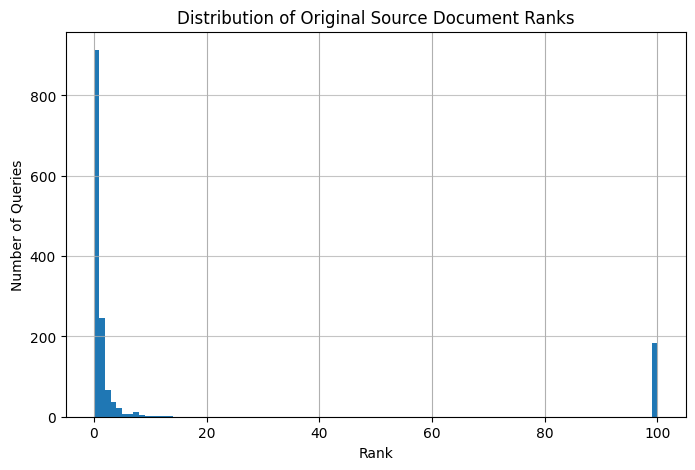

In [ ]:
import matplotlib.pyplot as plt
# Analysis of 'source_doc_rank'
# This column holds the rank (0 = top result) of the original document
# when searching the corpus with the synthetic query using the base model.

print("\n--- Analysis of Original Source Document Rank ---")
print("Summary statistics for the rank:")
# Provides mean, std deviation, min, max, and quartiles
print(df_train['source_doc_rank_fd'].describe())

# Visualize the distribution of ranks
print("\nDistribution of ranks (0 = Top Rank):")
plt.figure(figsize=(8, 5))
df_train['source_doc_rank_fd'].hist(bins=100)
plt.title('Distribution of Original Source Document Ranks')
plt.xlabel('Rank')
plt.ylabel('Number of Queries')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
print(f"After the RRF, the source document was ranked as 1st for {(len(df_train[df_train['source_doc_rank_fd']==0])/len(df_train))*100:.2f} % queries")
print(f"And was ranked in top-5 for {(len(df_train[df_train['source_doc_rank_fd'] < 5])/len(df_train))*100:.2f} % queries")

After the RRF, the source document was ranked as 1st for 60.70 % queries
And was ranked in top-5 for 85.31 % queries


### We have now successfully:

* Understood the need for specialized training data (positives and negatives).
* Implemented Gecko-inspired techniques to:
    * **Refine Positives:** Find the best matching positive document from our corpus for each query.
    * **Mine Hard Negatives:** Find challenging negative documents.

The resulting dataset is enhanced by improving the quality of positive documents and carefully selecting hard negative documents for more effective training.

### Next Steps:

In the upcoming notebook `05_finetuning.ipynb`, we will perform the actual model training. We plan to:

1.  Fine-tune a pre-trained embedding model using the initial, **uncurated** query-document pairs generated earlier (before the refinement steps in this notebook).
2.  Separately fine-tune the same pre-trained model using the **curated** dataset we just created (with refined positives and hard negatives).
3.  Evaluate and compare the retrieval performance of:
    * The original base model.
    * The model fine-tuned on the uncurated data.
    * The model fine-tuned on this curated dataset.

Comparing these methods in the next notebook will allow us to assess the effectiveness of the positive refinement and hard negative mining steps performed here.